# Laplace Equation
Laplace Equation은 비압축성, 비회전류 유동에서 정상상태일 때 Velocity Potential 또는 Streamfunction의 해이다.

$$
\nabla^2 u = 0.
$$

간단한 예제로 Heat Conduction에 의해 Steady State에 도달하는 경우를 생각하자

예를 들면, 윗면에 온도만 300도이고 나머지 면의 온도가 100도인 경우 최종적으로 2차원 공간 내 온도 분포는 Laplace Equation으로 구할 수 있다.

$[0,1]^2$ 공간에 대해 수식으로 표현하면 다음과 같다.

$$
-k (T_{xx} + T_{yy}) = 0\\
T(x,1) = 300, T(x, 0) = T(0, y) = T(1, y) = 100
$$

편의상 $k=1$ 로 생각한다.

### Finite Difference Method
그림과 같이 계산 영역을 x, y 각 방향별로 균일하게 나누어서 생각하자.

:::{figure-md} Grid
<img src="figures/2d_fd_grid.png">

Grid
:::

이 경우 2차원 Array는 각 격자점의 해와 부합한다.

각 방향별 편미분을 2차 정확도 Central Difference로 표현하면 다음과 같다.

$$
\frac {T_{i+1,j} -2 T_{i,j} +  T_{i-1,j}}{\Delta x^2}
+
+\frac {T_{i,j+1}^n -2 T_{i,j}^n +  T_{i,j-1}^n}{\Delta y^2}
=0
$$

$\Delta x = \Delta y = h$ 인 경우 다음과 같이 정리된다.

$$
T_{i+1,j} + T_{i,j+1} - 4 T_{i,j} + T_{i,j-1} + T_{i-1,j}
=0
$$

이를 Matrix 형태로 나타내면 다음과 같다.

$$
\left [
\begin{matrix}
-4 & 1 &   & 1 &   &   &   &   &
\\ 
 1 &-4 & 1 &   & 1 &   &   &   &
\\
   & 1 &-4 &   &   & 1 &   &   &
\\
 1 &   &   &-4 & 1 &   & 1 &   & 
\\
   & 1 &   & 1 &-4 & 1 &   & 1 & 
\\
   &   & 1 &   & 1 &-4 &   &   & 1
\\
   &   &   & 1 &   &   &-4 & 1 & 
\\
   &   &   &   & 1 &   & 1 &-4 & 1
\\
   &   &   &   &   & 1 &   & 1 &-4
\end{matrix}
\right ]
\left [
\begin{matrix}
T_{1,1} \\
T_{1,2} \\
T_{1,3} \\
T_{2,1} \\
T_{2,2} \\
T_{2,3} \\
T_{3,1} \\
T_{3,2} \\
T_{3,3} 
\end{matrix}
\right ]
=
\left [
\begin{matrix}
-T_{1,0} & -T_{0,1} \\ & -T_{0,2} \\ - T_{1,4} &-T_{0,3}  \\
-T_{2,0} & \\ 0 \\ -T_{2,4} &  \\
-T_{3,0} &-T_{4,1} \\ &-T_{4,2} \\ - T_{3,4}& -T_{4,3}
\end{matrix}
\right ]
$$

단 한번에 역행렬을 구함으로 써 모든 점에서 온도를 구할 수 있다.

다만 공간 차분 점이 늘어날수록 역행렬을 계산하는 시간이 급격하게 늘어난다.

### 예제
Laplace 행렬을 구성한 후 Linear System을 해석하시오.

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt

from iterative import cg
import numpy as np
import cupy as cp
import time
import cupyx.scipy.sparse.linalg as cuda_linalg

plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 150

In [2]:
def laplace_op(n):
    """
    Laplace operator
    
    Parameters
    ----------
    n : integer
        size of system
        
    Returns
    -------
    a : matrix
        operator
    """
    a = np.zeros((n*n,n*n))
    
    for i in range(n):
        for j in range(n):
            if i == j:
                for l in range(n):
                    for k in range(n):
                        ii = n*i + l
                        jj = n*j + k
                        
                        if l == k:
                            a[ii, jj] = -4
                        elif abs(l-k) == 1:
                            a[ii, jj] = 1
            elif abs(i-j) == 1:
                for l in range(n):
                    for k in range(n):
                        ii = n*i + l
                        jj = n*j + k
                        
                        if l == k:
                            a[ii, jj] = 1
    return a

In [3]:
def bc(n):
    """
    Solution array with BC
    """
    b = np.zeros(n*n)
    
    for i in range(n):
        for j in range(n):
            if i == n-1:
                # Top
                b[n*i + j] -= 300
            elif i == 0:
                # Bottom
                b[n*i + j] -= 100
            if j == n-1:
                # Right
                b[n*i + j] -= 100
            elif j == 0:
                # Left
                b[n*i + j] -= 100
                
    return b

In [11]:
# Construct operator
n = 59
a = laplace_op(n)
b = bc(n)

A = cp.asarray(a)
B = cp.asarray(b)

In [15]:
tt = cg(a, b)[0]

In [12]:
tt2 = cuda_linalg.cg(A,B)[0].get()

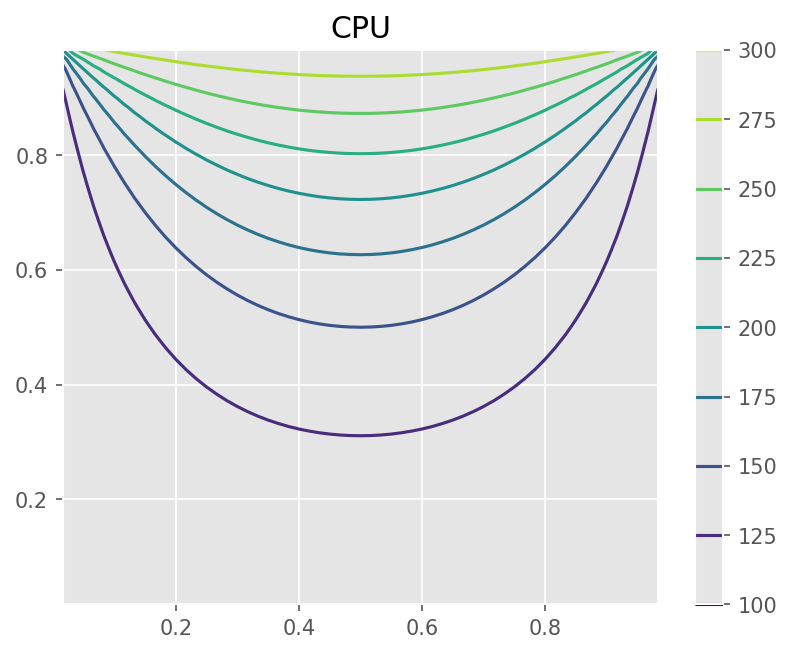

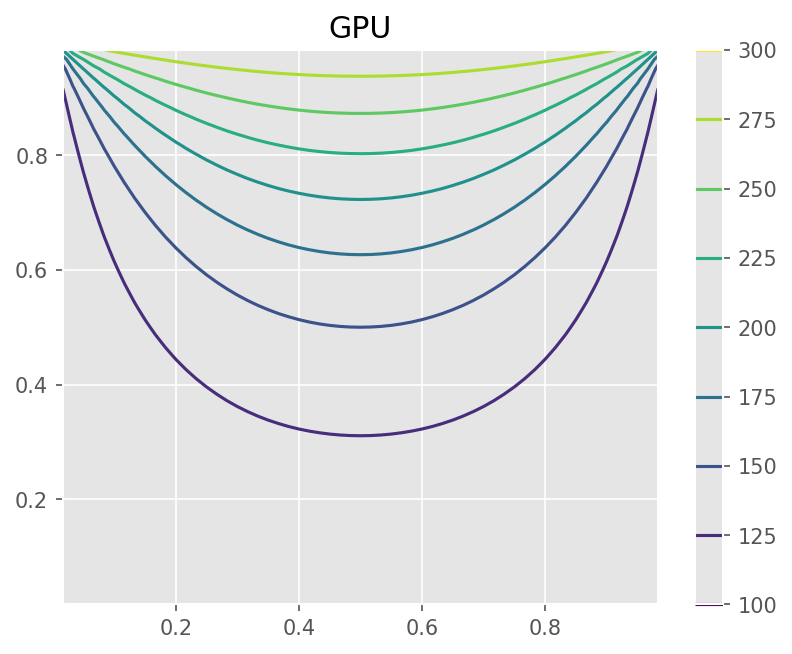

In [17]:
# Generate points (excluding BC)
xi = np.linspace(0, 1, n+2)
xx, yy = np.meshgrid(xi[1:-1], xi[1:-1])

# Plot contour
plt.contour(xx, yy, tt.reshape(n,n))
plt.title('CPU')
plt.colorbar()
plt.show()
plt.contour(xx, yy, tt2.reshape(n,n))
plt.title('GPU')
plt.colorbar()
plt.show()


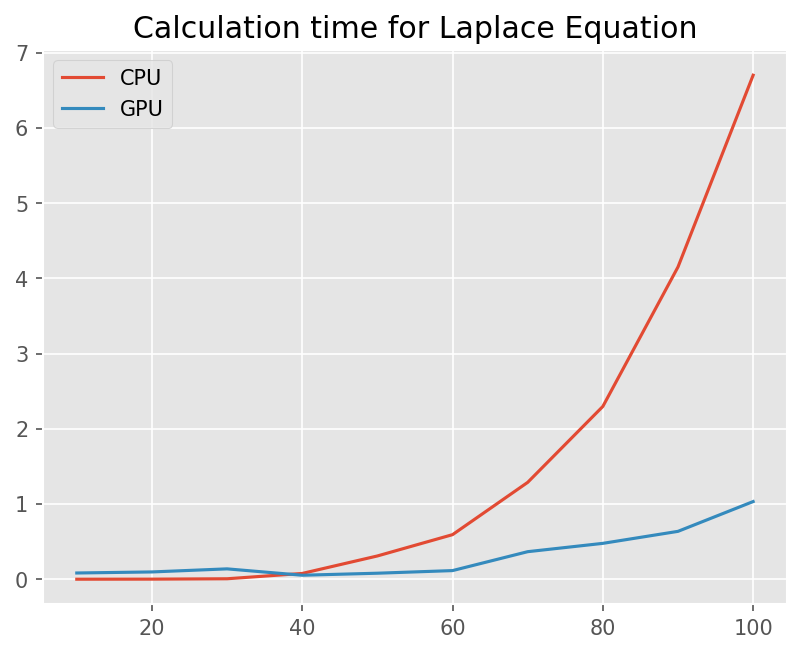

In [20]:
N = np.arange(10, 101, 10)
times_cpu = []
times_gpu = []

for n in N:

    # cpu용 Ax=b
    a = laplace_op(n)
    b = bc(n)

    # GPU용 Ax=b
    A = cp.asarray(a)
    B = cp.asarray(b)

    ts_cpu = time.time()
    sol_cpu = cg(a, b)[0]
    te_cpu = time.time()
    times_cpu.append(te_cpu-ts_cpu)

    ts_gpu = time.time()
    sol_gpu = cuda_linalg.cg(A,B)[0].get()
    te_gpu = time.time()
    times_gpu.append(te_gpu-ts_gpu)

    if np.linalg.norm(sol_cpu - sol_gpu) > 1e-5:
        print(f"Solution from n={n} doesn't match")
        break

plt.plot(N, times_cpu, label = 'CPU')
plt.plot(N, times_gpu, label ='GPU')
plt.title('Calculation time for Laplace Equation')
plt.legend()
plt.show()